In [1]:
import pandas as pd
import numpy as np
import difflib #find closests string matches
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
!#pip install pingouin
from pingouin import kruskal
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import StandardScaler



In [2]:
#load housing prices (#Address and agent info are encoded in the file and the URL isremoved.)
df = pd.read_csv('updated_housing_data.csv')
df.head()


,address,house_type,solddate,soldprice,asking_price,size,monthly_fee,agent,municipality,year,month
0,26090,1,2013-01-23,1675000.0,1760000.0,218.0,3300000.0,22,46,0,0
1,44999,1,2013-05-21,3500000.0,3745000.0,160.0,3300000.0,22,1,0,4
2,17857,1,2013-05-22,3295000.0,3851750.0,160.0,3300000.0,22,34,0,4
3,26409,1,2013-05-22,4350000.0,3958500.0,160.0,3300000.0,22,28,0,4
4,28195,1,2013-05-29,2730000.0,2484300.0,160.0,3300000.0,22,42,0,4


In [3]:
#categorical and numerical variables
qualitative = ['house_type','agent','municipality']
quantitative = ['asking_price','size','monthly_fee','year','month','soldprice']

### Numerical variables

<AxesSubplot:>

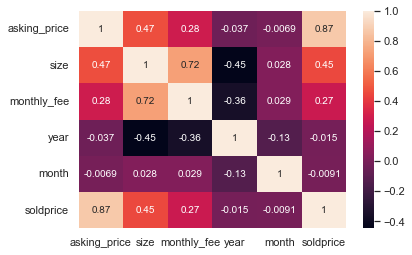

In [4]:
#Correlation between the continous, independent variables ('asking_price','size','monthly_fee','year','month') and the target variable ('soldprice').
sns.set(rc = {'figure.figsize':(8,8)})
sns.heatmap(df[quantitative].corr(),annot=True)

Here, we can notice the following relationships with the independent and the dependent variables.
- that asking_price has a strong postive correlation with the sale price of a house. 
- the size of a house has a moderately positive correlation with the sale price.
- monthly fee has a weak positive correlation with the sale price.
- year and month variables has an insignificant negative correlation with the sale price.

Now let's check whether any multicollinearity exists among the independednt variables.
- It can be noticed that between the size and the monthly fee there exists a strong postive correlation of 0.72. Hence we are going to drop the variable which has a weak correlation with target variable. in this case we drop monthly fee variable which has a 0.27 correlation with the sold price compared to the size variable which has a 0.45 correlation.


### Categorical variables

We can notice that there are three categorical variables. In the the next step, we are quantifying the association between these categorical variables and the continous variable soldprice. First, let's vizualize the distribution of the target variable sold price with respect to each of the categorical variables and their categories.

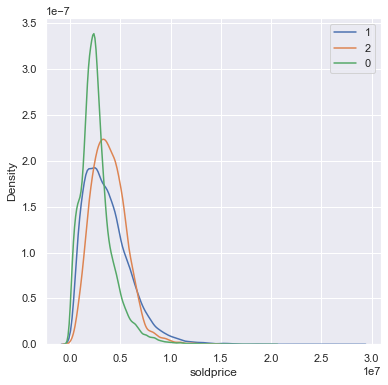

In [5]:
sns.set(rc = {'figure.figsize':(6,6)})

for i, h in enumerate( df['house_type'].unique()):
    filter_data = df[df['house_type']==h]['soldprice']
    
    sns.kdeplot(filter_data, label = h)
plt.legend()


We can notice that the mean sale prices for different house types (apartments (), houses, and townhouses ()) varu slightly.

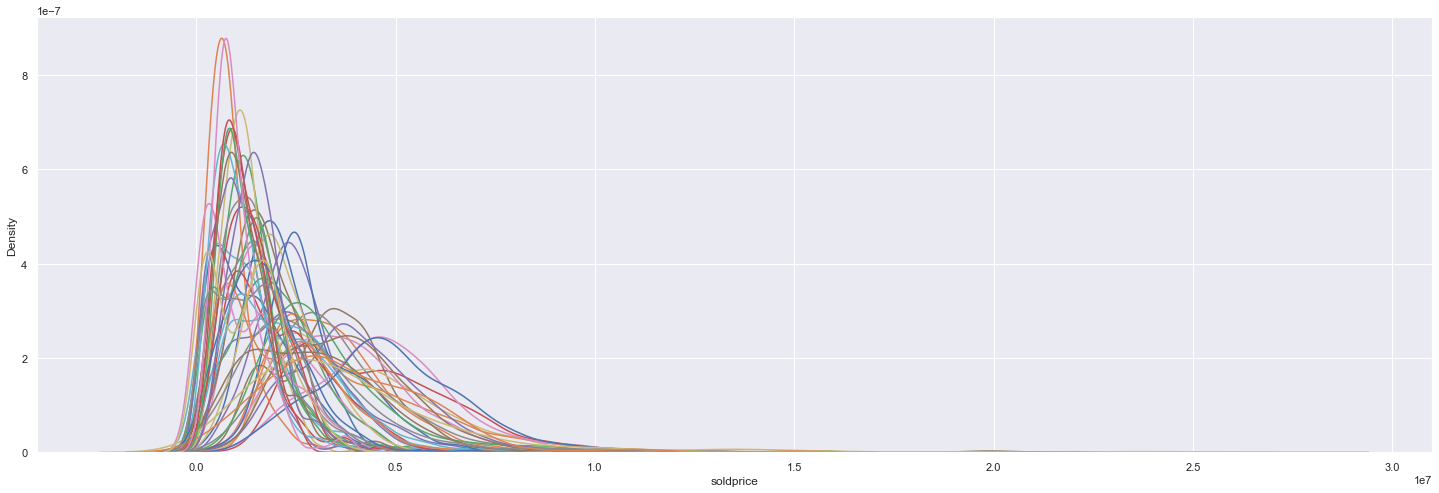

In [6]:
sns.set(rc = {'figure.figsize':(25,8)})

for i, h in enumerate( df['municipality'].unique()):
    filter_data = df[df['municipality']==h]['soldprice']
    
    sns.kdeplot(filter_data, label = h)


We can notice that the mean sale prices for different municipalities vary.

/Users/navodasenavirathne/learn_python/lesson01/.venv/lib/python3.9/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/Users/navodasenavirathne/learn_python/lesson01/.venv/lib/python3.9/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/Users/navodasenavirathne/learn_python/lesson01/.venv/lib/python3.9/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/Users/navodasenavirathne/learn_python/lesson01/.venv/lib/python3.9/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable 

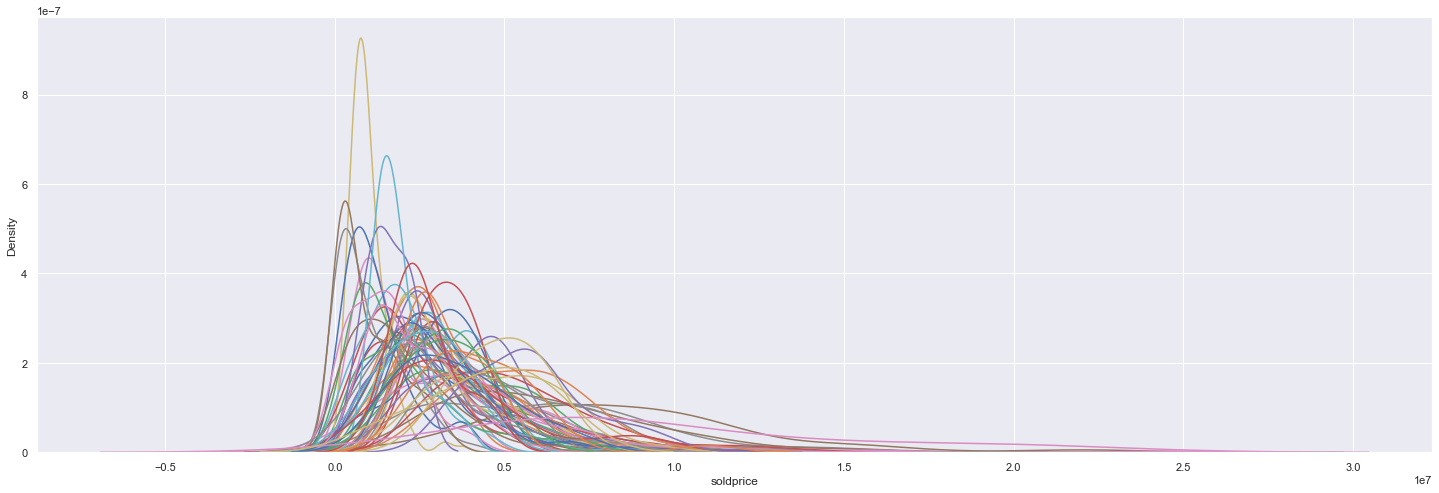

In [7]:
sns.set(rc = {'figure.figsize':(25,8)})

for i, h in enumerate( df['agent'].unique()):
    filter_data = df[df['agent']==h]['soldprice']
    
    sns.kdeplot(filter_data, label = h)


We can notice that the mean sale prices for different agents vary.

#### Association between the continous target variable and the categorical independent variables

In this part we are looking into the association between the target variable (continous) and the independent (categorical) variable. Sice they are respectively continous and categorical we cannot use methods like correlation or Cramer's V to quantify their relationships. Hence, we use Kruskal-Wallis Hypothesis test. This is a non-parametric test that does not make any assumption on the population distribution and can be used to indicate whether a statistically significant relationship exists between the variables of different types (categorical and numerical). 

#### Kruskal-Wallis Hypothesis test
- H0 - median sale prices are the same for all the groups.
- H1 - median sale prices are not equal for all the groups.

Here, the variable soldprice is grouped by the categories of the respective categorical variables.

If the p-val is < 0.05 we reject H0.

In [8]:
for var in qualitative:
    kr_res = kruskal(df, dv='soldprice', between=var)
    print(pd.DataFrame(kr_res),"\n")

             Source  ddof1            H  p-unc
Kruskal  house_type      2  4449.896024    0.0 

        Source  ddof1            H  p-unc
Kruskal  agent     68  6666.696726    0.0 

               Source  ddof1             H  p-unc
Kruskal  municipality     48  19973.397048    0.0 



In this example, the the corresponding p-values with respct to all three variables are less than 0.05. Hence, we reject the null hypothesis that the median sale prices are the same for all the groups. Hence, we can claim that the different housing types, municipalities, and real estate agents  lead to statistically significant differences in the sale prices of the properties.

However, the above results does not let us draw any conclusions with respect exactly which groups are different in terms of the median sale prices of the house. To answer this question we use Dunn's test with alpha value 0.05.

In [9]:
data_group = [] 
dunn_matrix_list = []
for var in qualitative:
    data_group.append(df.groupby(var)['soldprice'])

    grp_df = df.groupby(var)['soldprice']
    grp_df = [grp_df.get_group(x) for x in grp_df.groups]

    #!pip3 install scikit_posthocs
    import scikit_posthocs as sp
    dunn_matrix = sp.posthoc_dunn(grp_df, p_adjust = 'bonferroni')
    dunn_matrix_list.append(dunn_matrix)

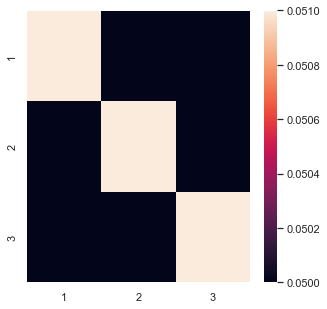

In [10]:
sns.set(rc = {'figure.figsize':(5,5)})
ax = sns.heatmap(dunn_matrix_list[0], vmin=0.05, vmax=0.051, cbar=True)

The above results indicate that median sale prices are different between the following groups apartments(1) and houses(2), apartments(1) and townhouses(3), and the houses(2) and townhouses(3).

The below heatmps shows the dunn's test values for rela estate agents and municipalities respectively. 

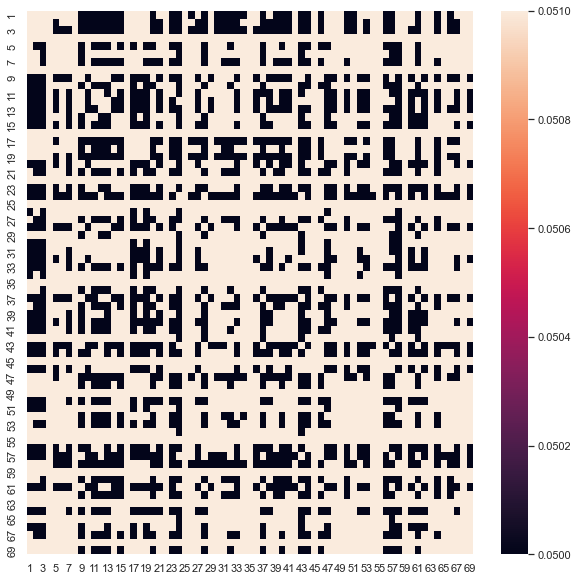

In [11]:
sns.set(rc = {'figure.figsize':(10,10)})
ax = sns.heatmap(dunn_matrix_list[1], vmin=0.05, vmax=0.051, cbar=True)

In [12]:
#sns.set(rc = {'figure.figsize':(20,20)})
#ax = sns.heatmap(dunn_matrix_list[2], vmin=0.05, vmax=0.051, cbar=True)

### Variable selection

In [13]:
#Select the requied variables - we remove the address, monthly fee (due to multi-collinerity,  solddate (as month and year represent this))
X=df[['house_type','asking_price','size','agent','municipality','year',	'month']]
y=df[['soldprice']]

In [14]:
#Split training and test data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=40)

In [15]:
#Numerical data standardization

quantitative = ['asking_price', 'size', 'year',	'month']
scaler = StandardScaler()

X_train[quantitative] = scaler.fit_transform(X_train[quantitative])
X_test[quantitative] = scaler.fit_transform(X_test[quantitative])


In [16]:
X_train=np.array(X_train)
X_test=np.array(X_test)
y_train=np.array(y_train)
y_test=np.array(y_test)

### Multiple Linear Regression with cross validation

In [17]:
mlm = make_pipeline(LinearRegression())
mcv = cross_validate(mlm, X_train, y_train,
    cv=10, scoring=["neg_mean_squared_error",'r2'],
    return_train_score=True,
    return_estimator=True)

mlm.fit(X_train, y_train)

Pipeline(steps=[('linearregression', LinearRegression())])

In [18]:
#Evaluation on the CV test data
print("Mean squared error : ",-mcv['test_neg_mean_squared_error'].mean(), "±", -mcv['test_neg_mean_squared_error'].std())
print("R squared : ",mcv['test_r2'].mean(), "±", mcv['test_r2'].std())

Mean squared error :  996942883927.7311 ± -68417702348.3295
R squared :  0.7630213291151715 ± 0.012456455077416086


### Polynomial linear regression with cross validation

In [19]:
#Polynomial linaer regression wirh cross validation
plm = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
pcv = cross_validate(plm, X_train, y_train,
    cv=10, scoring=["neg_mean_squared_error",'r2'],
    return_train_score=True,
    return_estimator=True)

plm.fit(X_train, y_train)



Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

In [20]:
#Evaluation on the CV test data
print("Mean squared error : ",-pcv['test_neg_mean_squared_error'].mean(), "±", -pcv['test_neg_mean_squared_error'].std())
print("R squared : ",pcv['test_r2'].mean(), "±", pcv['test_r2'].std())

Mean squared error :  952522214066.4148 ± -69966340938.41525
R squared :  0.773605652488986 ± 0.012822666490572008


R squared is a goodness of fit measure which indicates the percentage of the variance in the dependent variable (i.e., sold price) that can be explained by the independent variables.
Based on the R squared value it can be noted that the polynomial regression performs slightly better than the multiple linear regression.

In [21]:
res = [-mcv["train_neg_mean_squared_error"], -mcv["test_neg_mean_squared_error"],-pcv["train_neg_mean_squared_error"], -pcv["test_neg_mean_squared_error"]]


[Text(1, 0, 'Multiple LR - Training error'),
 Text(2, 0, 'Multiple LR - Test error'),
 Text(3, 0, 'Polynomial LR - Training error'),
 Text(4, 0, 'Polynomial LR - Test error')]

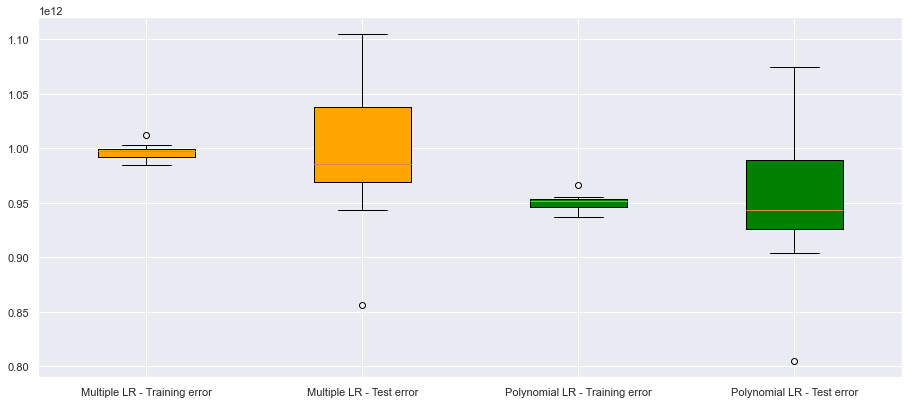

In [22]:
fig = plt.figure(figsize =(12, 5))
ax = fig.add_axes([0, 0, 1, 1])
bp=plt.boxplot(x=res, patch_artist = True, vert = 1)

colors = ['orange', 'orange',
          'green', 'green',
          'blue','blue']
 
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

labels = ['Multiple LR - Training error','Multiple LR - Test error','Polynomial LR - Training error','Polynomial LR - Test error']
ax.set_xticklabels(labels)


We can notice that the median test error for polynomial regression is lower than multiple linear regression. 

### Evaluation on the test data

#### Multiple linear regression

/Users/navodasenavirathne/learn_python/lesson01/.venv/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Predicted')

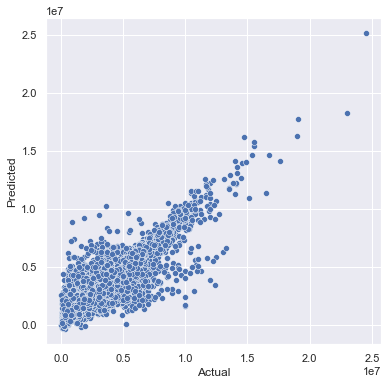

In [24]:
#predictions on test data
y_pred_mcv = mlm.predict(X_test)

#How predicted sale prices and actual sale prices change
sns.set(rc = {'figure.figsize':(6,6)})
sns.scatterplot(y_test.ravel(), y_pred_mcv.ravel())
plt.xlabel('Actual')
plt.ylabel('Predicted')


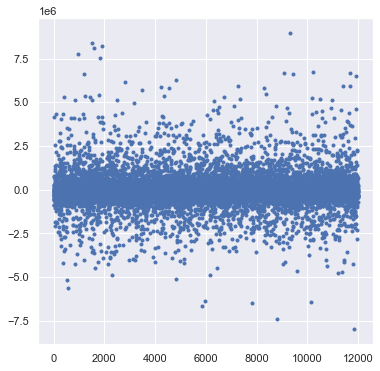

In [25]:
#Residual/error plot
plt.plot(y_test.ravel()- y_pred_mcv.ravel(), ls="", marker='.')

When both the assumption of linearity and homoscedasticity are met, the points in the residual/ error plot  will be randomly scattered as shown above.

#### Ploynomial regression

/Users/navodasenavirathne/learn_python/lesson01/.venv/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Predicted')

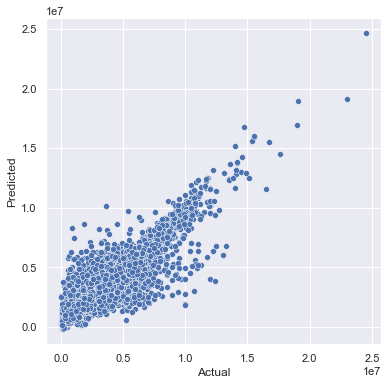

In [26]:
#predictions on test data
y_pred_pcv = plm.predict(X_test)

#How predicted sale prices and actual sale prices change
sns.set(rc = {'figure.figsize':(6,6)})
sns.scatterplot(y_test.ravel(), y_pred_pcv.ravel())
plt.xlabel('Actual')
plt.ylabel('Predicted')


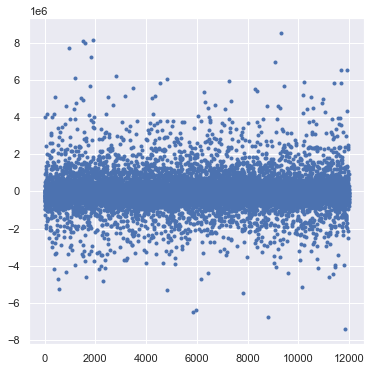

In [27]:
#Residual/error plot
plt.plot(y_test.ravel()- y_pred_pcv.ravel(), ls="", marker='.')

#### Comparison - mean_squared_error

In [29]:
multi_mse = mean_squared_error(y_test.ravel(), y_pred_mcv.ravel())
poly_mse = mean_squared_error(y_test.ravel(), y_pred_pcv.ravel())


In [30]:
multi_r2 = r2_score(y_test.ravel(), y_pred_mcv.ravel())
poly_r2 = r2_score(y_test.ravel(), y_pred_pcv.ravel())


In [31]:
multi_r2

0.7828340164504752

In [32]:
poly_r2

0.7940831503434951

We can note that all the models have a R2 score in the range of 0.78-0.79 indicating that even the simplest model we have developed has a good capability of explaining the variation of the housing prices.